<a href="https://colab.research.google.com/github/fumo88/TVML_notebooks/blob/master/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IEEE-CIS Fraud Detection - Kaggle Competition**
##Notebook per TVML - 18/04/2020
Link alla pagina della competition su Kaggle: https://www.kaggle.com/c/ieee-fraud-detection/overview

In [0]:
#ogni nb inizia cosi'
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#importo fastai tabular
from fastai.tabular import *

##**Caricamento dati e semplice visualizzazione**

In [0]:
# importo pandas per la manipolazione dati
import pandas as pd

In [0]:
#cambio cartella
import os
folder_path = "/content/drive/My Drive/Progetti_Data_Science/ieee-fraud-detection/"
os.chdir(folder_path)
os.getcwd()

'/content/drive/My Drive/Progetti_Data_Science/ieee-fraud-detection'

In [0]:
#vedo cosa c'e' nella cartella cosi' controllo se ho fatto giusto
!ls -all

total 5013086
drwx------ 2 root root       4096 Apr 18 15:41 models
-rw------- 1 root root     121834 Apr 11 10:42 my_test.csv
-rw------- 1 root root    6080314 Dec 11 22:12 sample_submission.csv
-rw------- 1 root root 1742578504 Apr 18 15:34 test.feather
-rw------- 1 root root   25797161 Dec 11 22:12 test_identity.csv
-rw------- 1 root root  613194934 Dec 11 22:12 test_transaction.csv
-rw------- 1 root root 2035739808 Apr 18 15:34 train.feather
-rw------- 1 root root   26529680 Dec 11 22:13 train_identity.csv
-rw------- 1 root root  683351067 Dec 11 22:13 train_transaction.csv


###Lettura Dati One-Time

In [0]:
%%time
#leggo tutti i file
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
#sub = pd.read_csv(f'{folder_path}sample_submission.csv')

CPU times: user 30.9 s, sys: 3.99 s, total: 34.9 s
Wall time: 49.5 s


In [0]:
%%time
#join dei dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 7.2 s, sys: 857 ms, total: 8.06 s
Wall time: 8.07 s


In [0]:
#print di alcune caratteristiche del nb
print(f'train_transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns.')
print(f'train_identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns.')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print('----------------------------')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

train_transaction dataset has 590540 rows and 394 columns.
train_identity dataset has 144233 rows and 41 columns.
Train dataset has 590540 rows and 434 columns.
----------------------------
Test dataset has 506691 rows and 433 columns.


In [0]:
#stampo i primi dati di train_transaction per vedere com'e'
#train_transaction.head()

In [0]:
#stampo i primi dati di train_identity per vedere com'e'
#train_identity.head()

In [0]:
#stampo i primi dati del dataset merged per vedere com'e'
#train.head()

In [0]:
#check per vedere se il numero di TransactionID unici è proprio uguale al numero di righe del dataset
#print('# TrID:', len(train['TransactionID'].unique()), ' - #TOTrecord:', len(train))

In [0]:
#scrivo un estratto del df train su file per aprirlo più agevolmente
#train[:100].to_csv("my_test.csv", sep=';', index=False) #decommento solo se voglio riscriverlo - sep per localizzazione Italia

In [0]:
#elimino quello che non serve, tengo solo il dataset principale (merged)
del train_identity, train_transaction, test_identity, test_transaction

In [0]:
%%time
train.to_feather(os.path.join(folder_path, 'train.feather'))
test.to_feather(os.path.join(folder_path, 'test.feather'))

CPU times: user 5.9 s, sys: 1.95 s, total: 7.85 s
Wall time: 1min 5s


###Caricamento rapido dati

In [0]:
%%time
train = pd.read_feather(os.path.join(folder_path, 'train.feather'))
test = pd.read_feather(os.path.join(folder_path, 'test.feather'))

CPU times: user 1.94 s, sys: 2.03 s, total: 3.97 s
Wall time: 3.47 s


In [0]:
#elimino solo la riga TransactionID, non voglio che l'algoritmo impari qual'e' l'identificativo unico di ogni riga e overfitti
# lascio il datetime perchè intanto i dati vengono mischiati (shuffled), quindi non dovrebbe essere un problema
TransactionID_train = train['TransactionID'];
train = train.drop(columns=['TransactionID'])
#train.head()

In [0]:
#butto via la prima colonna sia da train che da test
TransactionID_test = test['TransactionID'];
test = test.drop(columns=['TransactionID'])
#test.head()

###**Sbilanciamento Classi**

####EDA
Creo alcuni grafici utili:

In [0]:
#importo matplotlib per fare dei plot
import matplotlib.pyplot as plt

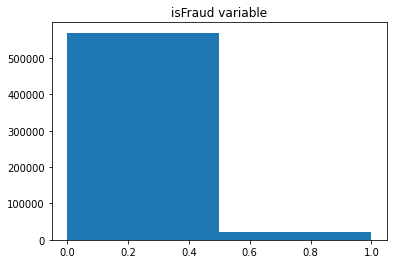

In [0]:
#voglio vedere come è distribuito il dataset in base alla variabile target isFraud
plt.hist(train['isFraud'], bins=2);
plt.title('isFraud variable');

In [0]:
#ok parecchio sbilanciata. Quanti 1 e quanti 0?
target_values_count = train['isFraud'].value_counts();
target_values_count

0    569877
1     20663
Name: isFraud, dtype: int64

In [0]:
fraud_percentage = 100 * target_values_count.iloc[1] / (target_values_count.iloc[0] + target_values_count.iloc[1]);
not_fraud_percentage = 100 * target_values_count.iloc[0] / (target_values_count.iloc[0] + target_values_count.iloc[1]);
print(f'Percentuale di record che sono frodi: {fraud_percentage:.2f} %')
print(f'Percentuale di record che NON sono frodi: {not_fraud_percentage:.2f} %')

Percentuale di record che sono frodi: 3.50 %
Percentuale di record che NON sono frodi: 96.50 %


####Bilanciamento con scikit learn
Le classi sono troppo sbilanciate, quindi conviene trovare un modo di fare stratified sampling. Cerco su google e trovo una funzione della libreria scikit-learn.

In [0]:
#importo scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit
#importo numpy
import numpy as np

In [0]:
#setto il seed random (cosi' avro' sempre gli stessi split)
np.random.seed(42)

#imposto la percentuale di dati da usare per il validation set 
valid_size_perc = 0.1

#dichiaro l'oggetto che usero' per splittare il dataset in modo stratificato
stratifier = StratifiedShuffleSplit(n_splits=1, test_size=valid_size_perc, train_size=(1-valid_size_perc))
stratifier.get_n_splits(np.zeros(len(train)), train['isFraud'])
#print(stratifier)
split_indices = stratifier.split(X=np.zeros(len(train)), y=train['isFraud'])

In [0]:
#recupero gli indici di train e test
train_split = None
valid_split = None 
for train_index, valid_index in split_indices:
  train_split = train_index.copy()
  valid_split = valid_index.copy()
  #print("TRAIN:", len(train_index), "Type TRAIN:", type(train_index), "TEST:", len(valid_index), "Type TEST:", type(valid_index))

#print("TRAIN:", len(train_split), "Type TRAIN:", type(train_split), "TEST:", len(valid_split), "Type TEST:", type(valid_split))

In [0]:
#output di prova per vedere se e' tutto ok
print("TRAIN:", len(train_split), "Type TRAIN:", type(train_split), "TEST:", len(valid_split), "Type TEST:", type(valid_split))

#check per vedere quanti frodi / non frodi ci sono
fraud_train = train['isFraud'].iloc[train_split]
fraud_test = train['isFraud'].iloc[valid_split]
print(f'Percentuale di fraud nel train: {sum(fraud_train)} / {len(fraud_train)} = {(sum(fraud_train) / len(fraud_train))*100:.2f} %')
print(f'Percentuale di fraud nel test: {sum(fraud_test)} / {len(fraud_test)} = {(sum(fraud_test) / len(fraud_test))*100:.2f} %')

TRAIN: 531486 Type TRAIN: <class 'numpy.ndarray'> TEST: 59054 Type TEST: <class 'numpy.ndarray'>
Percentuale di fraud nel train: 18597 / 531486 = 3.50 %
Percentuale di fraud nel test: 2066 / 59054 = 3.50 %


In [0]:
#check - head per vedere cosa tira fuori come dati
train_split[:10], valid_split[:10]

(array([401633, 305629, 281511, 534634, 184488, 416909, 406032, 162236, 279408, 583739]),
 array([ 51022, 381984,  54504,  99348,   3012, 152005, 354636, 556388, 151539, 190706]))

In [0]:
#adesso devo fare davvero lo shuffling
indici_shuffling = np.concatenate((train_split, valid_split))
train = train.reindex(index=indici_shuffling)
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
401633,0,10119241,58.95,W,7508,321.0,150.0,visa,226.0,debit,110.0,87.0,21.0,NaN,gmail.com,None,4.0,2.0,0.0,0.0,3.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,4.0,43.0,43.0,9.0,66.0,9.0,NaN,NaN,NaN,NaN,104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None
305629,0,7590553,125.00,R,18268,583.0,150.0,visa,226.0,credit,315.0,87.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,301.833344,0.833333,NaN,...,-5.0,79098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,33.0,-360.0,Found,Found,166.0,NaN,542.0,333.0,NaN,NaN,None,NaN,NaN,NaN,None,Found,Found,Mac OS X 10_13_3,chrome 63.0,24.0,4096x2304,match_status:2,T,F,T,F,desktop,MacOS
281511,0,6878332,39.00,W,17131,111.0,150.0,mastercard,224.0,debit,264.0,87.0,NaN,NaN,yahoo.com,None,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,11.0,1.0,425.0,259.0,22.0,425.0,42.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None
534634,0,14076632,59.00,W,5829,395.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,gmail.com,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None
184488,0,4105587,67.95,W,12293,109.0,150.0,mastercard,224.0,debit,327.0,87.0,NaN,NaN,yahoo.com,None,96.0,94.0,0.0,0.0,88.0,66.0,0.0,0.0,60.0,0.0,70.0,0.0,423.0,79.0,363.0,363.0,8.0,363.0,8.0,NaN,NaN,NaN,NaN,363.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None


##**Preprocessing**

**Categorical Features - Transaction**
*   ProductCD
*   card1 - card6
*   addr1, addr2
*   P_emaildomain
*   R_emaildomain
*   M1 - M9

**Categorical Features - Identity**
*   DeviceType
*   DeviceInfo
*   id_12 - id_38

In [0]:
cat_names = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])

id_cols = ['TransactionID', 'TransactionDT']
type_map = {c: str for c in cat_names}

dep_var = 'isFraud'

cont_names = [c for c in train.columns.tolist() if c not in cat_names + id_cols + [dep_var]]

tricky_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

print('ID cols:', len(id_cols), '->', id_cols)
print('Target col:', dep_var)
print('Categorical cols:', len(cat_names))
print('Numeric cols:', len(cont_names))
print('Train lenght:', len(train))
print('Test lenght:', len(test))
print('\nCategory fields:', ', '.join(cat_names))
print('\nNumeric fields:', ', '.join(cont_names))

ID cols: 2 -> ['TransactionID', 'TransactionDT']
Target col: isFraud
Categorical cols: 49
Numeric cols: 382
Train lenght: 590540
Test lenght: 506691

Category fields: ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, P_emaildomain, R_emaildomain, M1, M2, M3, M4, M5, M6, M7, M8, M9, DeviceType, DeviceInfo, id_12, id_13, id_14, id_15, id_16, id_17, id_18, id_19, id_20, id_21, id_22, id_23, id_24, id_25, id_26, id_27, id_28, id_29, id_30, id_31, id_32, id_33, id_34, id_35, id_36, id_37, id_38

Numeric fields: TransactionAmt, dist1, dist2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65

In [0]:
#modifico i nomi di alcune colonne del test, sono diverse dal train
cols_to_change = test.columns[392:430].to_list(); #cols_to_change
cols_to_change = [cc.replace('-', '_') for cc in cols_to_change];
mymapper = dict(zip(test.columns[392:430].to_list(), cols_to_change))
test.rename(columns=mymapper, inplace=True)

#check per vedere se ha funzionato
print('Test Column names: ', ', '.join(test.columns.to_list()))

Test Column names:  TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, V81, V82, V83, V84, V85, V86, V87, V88, V89, V90, V91, V92, V93, V94, V95, V96, V97, V98, V99, V100, V101, V102, V103, V104, V105, V106, V107, V108, V109, V110, V111, V112, V113, V114, V115, V116, V117, V118, V119, V120, V121, V122, V123, V124, V125, V126, V127, V128, V129, V130, V13

In [0]:
%%time
# deal with nan discrepancy between testing and training 

print(len(train))
t_fixes = []
for c in tricky_cols:
    print(c)
    for i in range(sum(test[c].isna().astype(int))*1):
        t_fix = train.iloc[random.randint(0, 300_000)].copy()
        t_fix[c] = np.nan
        t_fixes.append(t_fix)
        
train = train.append(t_fixes, ignore_index=True)
print(len(train), len(t_fixes))


590540
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
595327 4787
CPU times: user 5.11 s, sys: 459 ms, total: 5.57 s
Wall time: 5.4 s


## **fastai Pipeline**

###DataBunch

In [0]:
#Configurazione parametri fastai
bs = 20_000
procs = [FillMissing, Categorify, Normalize]

In [0]:
%%time
#creo un TabularDataBunch
data = TabularDataBunch.from_df(path=folder_path, df=train, dep_var=dep_var, valid_idx=list(valid_split), procs=procs, cat_names=cat_names, cont_names=cont_names, bs=bs, test_df=test)

CPU times: user 1min 25s, sys: 5.29 s, total: 1min 30s
Wall time: 1min 28s


In [0]:
#visualizzo un po' di dati per vedere che sia tutto ok
data.show_batch(rows=5)

ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,dist1_na,dist2_na,C1_na,C2_na,C3_na,C4_na,C5_na,C6_na,C7_na,C8_na,C9_na,C10_na,C11_na,C12_na,C13_na,C14_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,V1_na,V2_na,V3_na,V4_na,V5_na,V6_na,V7_na,V8_na,V9_na,V10_na,V11_na,V12_na,V13_na,V14_na,V15_na,V16_na,V17_na,V18_na,V19_na,V20_na,V21_na,V22_na,V23_na,V24_na,V25_na,V26_na,V27_na,V28_na,V29_na,V30_na,V31_na,V32_na,V33_na,V34_na,V35_na,V36_na,V37_na,V38_na,V39_na,V40_na,V41_na,V42_na,V43_na,V44_na,V45_na,V46_na,V47_na,V48_na,V49_na,V50_na,V51_na,V52_na,V53_na,V54_na,V55_na,V56_na,V57_na,V58_na,V59_na,V60_na,V61_na,V62_na,V63_na,V64_na,V65_na,V66_na,V67_na,V68_na,V69_na,V70_na,V71_na,V72_na,V73_na,V74_na,V75_na,V76_na,V77_na,V78_na,V79_na,V80_na,V81_na,V82_na,V83_na,V84_na,V85_na,V86_na,V87_na,V88_na,V89_na,V90_na,V91_na,V92_na,V93_na,V94_na,V95_na,V96_na,V97_na,V98_na,V99_na,V100_na,V101_na,V102_na,V103_na,V104_na,V105_na,V106_na,V107_na,V108_na,V109_na,V110_na,V111_na,V112_na,V113_na,V114_na,V115_na,V116_na,V117_na,V118_na,V119_na,V120_na,V121_na,V122_na,V123_na,V124_na,V125_na,V126_na,V127_na,V128_na,V129_na,V130_na,V131_na,V132_na,V133_na,V134_na,V135_na,V136_na,V137_na,V138_na,V139_na,V140_na,V141_na,V142_na,V143_na,V144_na,V145_na,V146_na,V147_na,V148_na,V149_na,V150_na,V151_na,V152_na,V153_na,V154_na,V155_na,V156_na,V157_na,V158_na,V159_na,V160_na,V161_na,V162_na,V163_na,V164_na,V165_na,V166_na,V167_na,V168_na,V169_na,V170_na,V171_na,V172_na,V173_na,V174_na,V175_na,V176_na,V177_na,V178_na,V179_na,V180_na,V181_na,V182_na,V183_na,V184_na,V185_na,V186_na,V187_na,V188_na,V189_na,V190_na,V191_na,V192_na,V193_na,V194_na,V195_na,V196_na,V197_na,V198_na,V199_na,V200_na,V201_na,V202_na,V203_na,V204_na,V205_na,V206_na,V207_na,V208_na,V209_na,V210_na,V211_na,V212_na,V213_na,V214_na,V215_na,V216_na,V217_na,V218_na,V219_na,V220_na,V221_na,V222_na,V223_na,V224_na,V225_na,V226_na,V227_na,V228_na,V229_na,V230_na,V231_na,V232_na,V233_na,V234_na,V235_na,V236_na,V237_na,V238_na,V239_na,V240_na,V241_na,V242_na,V243_na,V244_na,V245_na,V246_na,V247_na,V248_na,V249_na,V250_na,V251_na,V252_na,V253_na,V254_na,V255_na,V256_na,V257_na,V258_na,V259_na,V260_na,V261_na,V262_na,V263_na,V264_na,V265_na,V266_na,V267_na,V268_na,V269_na,V270_na,V271_na,V272_na,V273_na,V274_na,V275_na,V276_na,V277_na,V278_na,V279_na,V280_na,V281_na,V282_na,V283_na,V284_na,V285_na,V286_na,V287_na,V288_na,V289_na,V290_na,V291_na,V292_na,V293_na,V294_na,V295_na,V296_na,V297_na,V298_na,V299_na,V300_na,V301_na,V302_na,V303_na,V304_na,V305_na,V306_na,V307_na,V308_na,V309_na,V310_na,V311_na,V312_na,V313_na,V314_na,V315_na,V316_na,V317_na,V318_na,V319_na,V320_na,V321_na,V322_na,V323_na,V324_na,V325_na,V326_na,V327_na,V328_na,V329_na,V330_na,V331_na,V332_na,V333_na,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,

###Modello

In [0]:
#creo il tabular_learner
learn = tabular_learner(data, layers=[300, 50], metrics=accuracy, callback_fns=ShowGraph)

In [0]:
#visualizzazione modello
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(12822, 320)
    (2): Embedding(501, 52)
    (3): Embedding(114, 23)
    (4): Embedding(5, 4)
    (5): Embedding(116, 23)
    (6): Embedding(5, 4)
    (7): Embedding(305, 39)
    (8): Embedding(70, 17)
    (9): Embedding(60, 16)
    (10): Embedding(61, 16)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(4, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(54, 15)
    (22): Embedding(25, 10)
    (23): Embedding(4, 3)
    (24): Embedding(3, 3)
    (25): Embedding(102, 21)
    (26): Embedding(18, 8)
    (27): Embedding(518, 53)
    (28): Embedding(384, 45)
    (29): Embedding(434, 48)
    (30): Embedding(25, 10)
    (31): Embedding(4, 3)
    (32): Embedding(12, 6)
    (33): Embedding(324, 41)
    (34): Embedding(92, 20)
    (35): Emb

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 9.12E-02
CPU times: user 26.8 s, sys: 5.76 s, total: 32.5 s
Wall time: 46.2 s


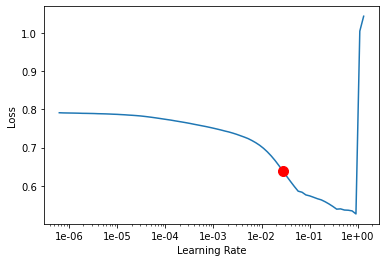

In [0]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.586538,0.287115,0.963914,00:13
1,0.295995,0.096905,0.973600,00:13
2,0.181859,0.076569,0.978901,00:13
3,0.126308,0.073586,0.979883,00:13
4,0.094546,0.066354,0.981762,00:13
5,0.074568,0.061676,0.983236,00:13
6,0.060052,0.060261,0.983490,00:13
7,0.049074,0.058898,0.983947,00:13
8,0.040497,0.058557,0.984929,00:13
9,0.034299,0.059205,0.984827,00:13


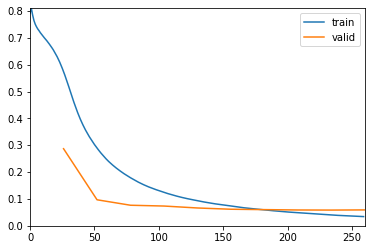

In [0]:
#faccio partire il training
learn.fit_one_cycle(10, max_lr=3e-2)

In [0]:
learn.save('after-solution-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

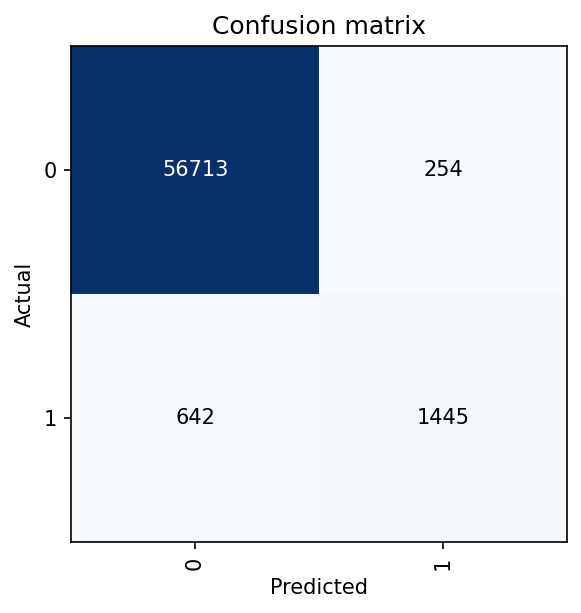

In [0]:
interp.plot_confusion_matrix(dpi=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 6.31E-08
CPU times: user 26.2 s, sys: 5.01 s, total: 31.2 s
Wall time: 44.9 s


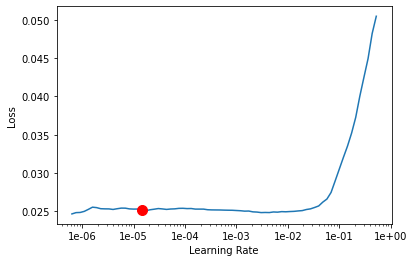

In [0]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.load('after-solution-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.025100,0.059275,0.984726,00:13


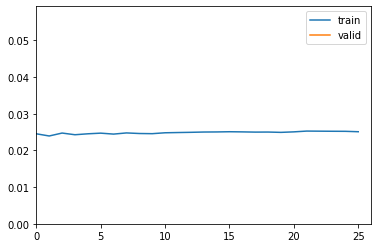

In [0]:
#faccio un altro giro di training, più breve
learn.fit_one_cycle(1, max_lr=1e-5)

Di più non serve, è necessario fare del preprocessing più avanzato.

In [0]:
learn.save('after-solution-2')

##**Prediction per competition Kaggle**

In [0]:
%%time
learn.load('after-solution-1')

CPU times: user 211 ms, sys: 58.2 ms, total: 269 ms
Wall time: 297 ms


Learner(data=TabularDataBunch;

Train: LabelList (536273 items)
x: TabularList
ProductCD W; card1 7508; card2 321.0; card3 150.0; card4 visa; card5 226.0; card6 debit; addr1 110.0; addr2 87.0; P_emaildomain gmail.com; R_emaildomain #na#; M1 T; M2 T; M3 T; M4 #na#; M5 #na#; M6 T; M7 F; M8 F; M9 T; DeviceType #na#; DeviceInfo #na#; id_12 #na#; id_13 #na#; id_14 #na#; id_15 #na#; id_16 #na#; id_17 #na#; id_18 #na#; id_19 #na#; id_20 #na#; id_21 #na#; id_22 #na#; id_23 #na#; id_24 #na#; id_25 #na#; id_26 #na#; id_27 #na#; id_28 #na#; id_29 #na#; id_30 #na#; id_31 #na#; id_32 #na#; id_33 #na#; id_34 #na#; id_35 #na#; id_36 #na#; id_37 #na#; id_38 #na#; dist1_na False; dist2_na True; C1_na False; C2_na False; C3_na False; C4_na False; C5_na False; C6_na False; C7_na False; C8_na False; C9_na False; C10_na False; C11_na False; C12_na False; C13_na False; C14_na False; D1_na False; D2_na False; D3_na False; D4_na False; D5_na False; D6_na True; D7_na True; D8_na True; D9_na True; D10_na False;

In [0]:
%%time
#richiedo le predizioni
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 1.28 s, sys: 917 ms, total: 2.19 s
Wall time: 9.26 s


In [0]:
#creo il file da sottomettere
df_submission = pd.DataFrame(TransactionID_test.copy())
df_submission['isFraud'] = np.nan_to_num(preds[:, 1].numpy())
df_submission.to_csv('my_submission.csv', index=False, float_format='%.7f')

Setup di Kaggle:

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emanuelef","key":"d1eb416cc26610e3c86d42355cd16857"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions submit -c ieee-fraud-detection -f my_submission.csv -m "after solution 1"

100% 8.70M/8.70M [00:06<00:00, 1.32MB/s]
Successfully submitted to IEEE-CIS Fraud Detection